This section reviews the various methods for reading and modifying metadata within a ReproPhylo `Project`. Utilizing it will be discussed in later sections.
## 3.4.1 What is metadata in ReproPhylo?
Within a ReproPhylo `Project`, metadata is tied to sequences and sequence features, in the Biopython sense. Since sequence records in the `Project` are in fact Biopython `SeqRecord` objects, a quick review of the GenBank file format, based on which the `SeqRecord` class is structured, will help understand basic concepts.

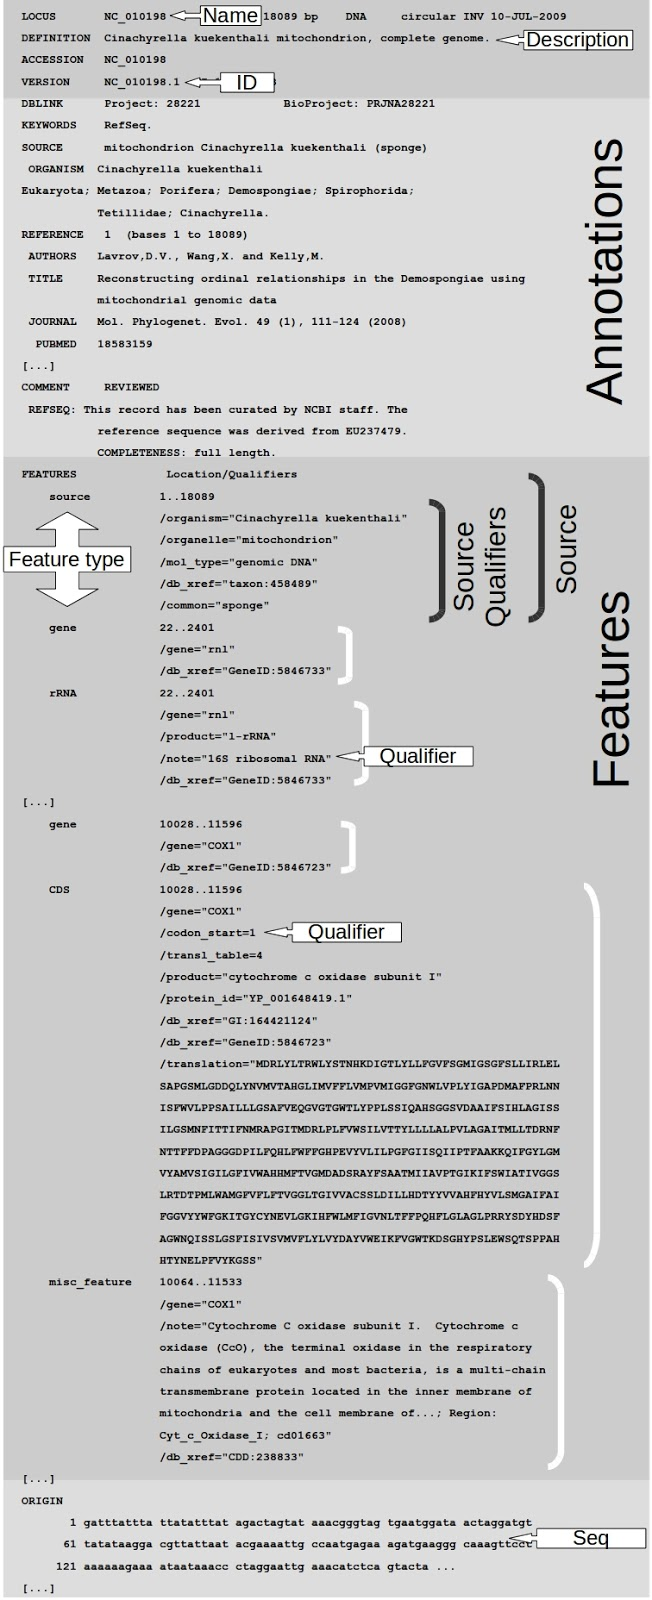

In [1]:
from IPython.display import Image
Image('images/genbank_terminology.jpg', width=400)

When a data file is read, each sequence will be stored as a `SeqRecord` object in the `Project.records` list of `SeqRecord` objects. A `SeqRecord` object has an `annotations` attribute (`SeqRecord.annotations`) which is a Python dictionary containing information regarding the sequence as a whole. Additional `SeqRecord` attribute is the `features` Python list (`SeqRecord.features`). Features in the list are stored as `SeqFeature` Biopython objects, and they define the start and end of each locus in the sequence (`SeqFeature.location` attribute. The `SeqFeature` also has the `SeqFeature.qualifiers` dictionary, which holds any additional metadata about this sequence feature. For example, the gene name and product name. This information is used by ReproPhylo to sort loci into their respective bins, (eg, coi, 18S etc.). Note that the values in the `SeqFeature.qualifiers` dictionary are always stored as Python lists, even if they consist of a single value. For example, a `SeqFeature.qualifiers` dictionary might look like this:
<pre>
{'gene': ['cox1'],
'translation': ['AATRNLLK']}
</pre>
Another important `SeqRecord` attribute is `type` (`SeqRecord.type`), which is a string stating the feature type, whether it is 'gene', 'CDS', 'rRNA' or anything else.  
A special `SeqFeature` is the source feature (`SeqFeature.type == 'source'`). It is the first feature in each `SeqRecord.features` list, and is generated automatically by ReproPhylo if you read a file that does not have such features (eg, fasta format). The `qualifiers` dictionary of this automatically generated source feature will then contain the `original_id` and `original_desc` (description) from the fasta headers. Technically, there is absolutely no difference between the source feature and all the other features. However, conceptually, metadata stored in the source feature applies to all the other features. ReproPhylo knows this and provides tools to access it accordingly (further down).

For a more detailed description of metadata in the `SeqRecord` Biopython object, refer to this [section](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc31) in the Biopython [tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html). Although ReproPhylo provides some `Project` methods for modifying the metadata, and also a method to edit the metadata in a spreadsheet, the most flexible way to do it is by utilizing Biopython code, and mastering it is helpful within ReproPhylo and in life in general!

## 3.4.2 Modifying the metadata
### 3.4.2.1 A Biopython example
With Biopython we can iterate over the records and their features in the `pj.records` list and make changes or additions to the qualifiers of each feature as follows. To get a working example going, first we load our project with its loci and data:

In [2]:
from reprophylo import *
pj = unpickle_pj('outputs/my_project.pkpj', git=False)

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened


The first record looks like this:

In [3]:
print pj.records[0].format('genbank')

LOCUS       KC902343                1728 bp    DNA              INV 05-SEP-2013
DEFINITION  Cinachyrella cf. paterifera 0M9H2022-P small subunit 18S ribosomal
            RNA gene, partial sequence.
ACCESSION   KC902343
VERSION     KC902343.1  GI:511637204
KEYWORDS    .
SOURCE      Cinachyrella cf. paterifera 0M9H2022-P
  ORGANISM  Cinachyrella cf. paterifera 0M9H2022-P
            Eukaryota; Metazoa; Porifera; Demospongiae; Tetractinomorpha;
            Spirophorida; Tetillidae; Cinachyrella.
REFERENCE   1  (bases 1 to 1728)
  AUTHORS   Redmond,N.E., Morrow,C.C., Thacker,R.W., Diaz,M.C.,
            Boury-Esnault,N., Cardenas,P., Hajdu,E., Lobo-Hajdu,G., Picton,B.E.,
            Pomponi,S.A., Kayal,E. and Collins,A.G.
  TITLE     Phylogeny and Systematics of Demospongiae in Light of New
            Small-Subunit Ribosomal DNA (18S) Sequences
  JOURNAL   Integr. Comp. Biol. 53 (3), 388-415 (2013)
   PUBMED   23793549
REFERENCE   2  (bases 1 to 1728)
  AUTHORS   Redmond,N. and Collins,A

The next cell will get the organism name for each record, which is a qualifier in the source feature. It will then get the genus out of this name, and place it in a new qualifier, in all the record's features:

In [4]:
for record in pj.records:
    
    # get the source qualifiers
    source_feature = record.features[0]
    source_qualifiers = source_feature.qualifiers
    
    # get the species name
    species = None
    if 'organism' in source_qualifiers:
        species = source_qualifiers['organism'][0] # qualifier values are lists
        
    # place the genus as a qualifier in all the features
    if species:
        genus = species.split()[0]
        for f in record.features:
            f.qualifiers['genus'] = [genus]
    

The `genus` qualifier was added to all the features.

In [5]:
print pj.records[0].format('genbank')

LOCUS       KC902343                1728 bp    DNA              INV 05-SEP-2013
DEFINITION  Cinachyrella cf. paterifera 0M9H2022-P small subunit 18S ribosomal
            RNA gene, partial sequence.
ACCESSION   KC902343
VERSION     KC902343.1  GI:511637204
KEYWORDS    .
SOURCE      Cinachyrella cf. paterifera 0M9H2022-P
  ORGANISM  Cinachyrella cf. paterifera 0M9H2022-P
            Eukaryota; Metazoa; Porifera; Demospongiae; Tetractinomorpha;
            Spirophorida; Tetillidae; Cinachyrella.
REFERENCE   1  (bases 1 to 1728)
  AUTHORS   Redmond,N.E., Morrow,C.C., Thacker,R.W., Diaz,M.C.,
            Boury-Esnault,N., Cardenas,P., Hajdu,E., Lobo-Hajdu,G., Picton,B.E.,
            Pomponi,S.A., Kayal,E. and Collins,A.G.
  TITLE     Phylogeny and Systematics of Demospongiae in Light of New
            Small-Subunit Ribosomal DNA (18S) Sequences
  JOURNAL   Integr. Comp. Biol. 53 (3), 388-415 (2013)
   PUBMED   23793549
REFERENCE   2  (bases 1 to 1728)
  AUTHORS   Redmond,N. and Collins,A

**Important**:  
In addition to the record ID, ReproPhylo assigns a unique *feature ID* for each feature within the record. In a record with a record ID `KC902343`, the ID of the first feature will be `KC902343_source`, for the second and third features the IDs will be `KC902343_f0` and `KC902343_f1` and so on. For a record with a record ID `denovo2`, the features will get the feature IDs `denovo2_source`, `denovo2_f0`, `denovo2_f1` and so on. This is important because it allows to access specific features directly (say, the cox1 features), using their feature ID. 

### 3.4.2.2 Some ReproPhylo shortcuts
ReproPhylo adds some basic shortcuts for convenience. Here are some examples:

In [6]:
pj.if_this_then_that('Cinachyrella', 'genus', 'yes', 'porocalices', mode='part')

This method iterates over all the records in the project and makes some changes where the rules provided to it apply. If the **value 'Cinachyrella'** is found in the **qualifier 'genus'** it will put the **value 'yes'** in the **qualifier 'porocalices'**, which is a morphological trait of the sponge genus *Cinachyrella*. **mode='part'** means that the match can be partial. The default is mode='whole'.
 

In [7]:
features_to_modify = ['KC902343.1_f0', 'JX177933.1_f0']
pj.add_qualifier(features_to_modify, 'spam?', 'why not')

This method will add a qualifier **spam?** with the value **why not** to specific features that have the feature IDs **KC902343.1_f0** and **JX177933.1_f0**. Within each record, ReproPhylo assigns unique ID for each feature.

In [8]:
pj.add_qualifier_from_source('country')

We may want to place the source qualifier **'country'**  explicitly in each of the other features. The **`add_qualifier_from_source`** method will take effect in all the records that have a `country` qualifier in their source feature. It will copy it to all the other features in the record, along with its value in that record.

In [9]:
pj.copy_paste_from_features_to_source('eggs?', 'spam?')

Or vice-versa, we can make sure that a qualifier that is in only one of the features, is copied as a value of a source feature qualifier and thus apply it to the whole record (and all its features). In this case, the function **copy_paste_from_features_to_source** will take effect in records where at least one non-source record feature has the qualifier **eggs?**, and it will copy the value of **eggs?** to the source qualifier **spam?**. 

In [10]:
pj.copy_paste_within_feature('GC_content', '%GC')

Lastly, we may want to equate qualifiers that have different names in different records, but are essentially the same thing. For example, 'sample' and 'voucher'. This can be done by applying the qualifier name of one of them
to the other, using the method **copy_paste_within_feature**. In every record feature that has the qualifier **GC_content**, a new qualifier will be created, **%GC**, and it will contain the value of **GC_content**.

This is the FEATURES section of the above record, with the resulting changes to it. The method which is responsible for each qualifier is indicated next to it (the method names are not a part of the real output):

<pre>

FEATURES             Location/Qualifiers
     source          1..1728
                     /feature_id="KC902343.1_source"
                     /mol_type="genomic DNA"
                     /country="Australia"
                     /eggs?="why not" #### copy_paste_from_features_to_source
                     /note="PorToL ID: NCI376"
                     /db_xref="taxon:1342549"
                     /specimen_voucher="0M9H2022-P"
                     /genus="Cinachyrella" #### Biopython script from section 3.4.2.1
                     /organism="Cinachyrella cf. paterifera 0M9H2022-P"
     rRNA            <1..>1728
                     /porocalices="yes" ####if_this_then_that
                     /product="small subunit 18S ribosomal RNA"
                     /country="Australia" #### add_qualifier_from_source
                     /nuc_degen_prop="0.0"
                     /feature_id="KC902343.1_f0"
                     /spam?="why not" #### add_qualifier
                     /%GC="52.0833333333" #### copy_paste_within_feature
                     /GC_content="52.0833333333"
                     /genus="Cinachyrella" #### Biopython script from section 3.4.2.1
</pre>

### 3.4.2.2 Using a spreadsheet

ReproPhylo provides an alternative route for metadata editing that goes through a spreadsheet. This way, the spreadsheet can be routinely edited and the changes read into the `Project` and propagated to its existing components (eg, trees). The best way to edit this spreadsheet probably goes through [pandas](http://pandas.pydata.org/), if you are familiar with it. Otherwise, it is possible to edit and save in excel, libreoffice and similar programmes, although beware of [errors](https://nsaunders.wordpress.com/2012/10/22/gene-name-errors-and-excel-lessons-not-learned/).  
  
In this section I will give an example using a spreadsheet programme. This example will add the qualifier 'monty' and the value 'python' to each *source* feature, and the qualifier 'holy' with the value 'grail' to each *non-source* feature.   
  
The first step is to write a csv file (the separators are actually tabs and not commas)

In [11]:
pj.write('outputs/metadata_example.tsv', format='csv')

In the resulting file, each ***feature*** has its own line, and each record has as many lines as non-source features it contains. Source feature qualifiers are included in all the lines, as they apply to all the features in the record. They are indicated in the titles with the prefix `source:_`. To add a qualifier to the source feature, we will need to use this prefix in its title.  
  
I have opened this file in a spreadsheet programme and added the qualifiers as follows:

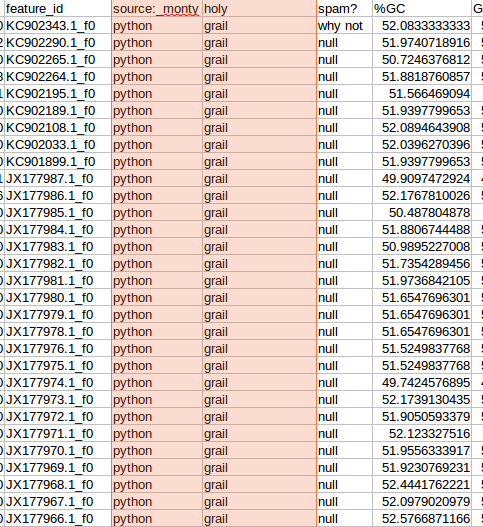

In [12]:
from IPython.display import  Image
Image('images/spreadsheet.png', width=400)

The edited spreadsheet was saved as `outputs/edited_metadata_example.tsv`, and it can now be read back to the `Project`

In [13]:
pj.correct_metadata_from_file('outputs/edited_metadata_example.tsv')

# Propagate the changes so they are also updated in tree leaves.
pj.propagate_metadata()

If we print the first record again, this is how its FEATURES section looks now:
<pre>
FEATURES             Location/Qualifiers
     source          1..1728
                     /note="PorToL ID: NCI376"
                     /mol_type="genomic DNA"
                     /country="Australia"
                     /organism="Cinachyrella cf. paterifera 0M9H2022-P"
                     /feature_id="KC902343.1_source"
                     /db_xref="taxon:1342549"
                     /specimen_voucher="0M9H2022-P"
                     /genus="Cinachyrella"
                     /eggs?="why not"
                     /monty="python"  #### New source qualifier
     rRNA            <1..>1728
                     /porocalices="yes"
                     /product="small subunit 18S ribosomal RNA"
                     /holy="grail"    #### New non-source qualifier
                     /country="Australia"
                     /nuc_degen_prop="0"
                     /feature_id="KC902343.1_f0"
                     /%GC="52.0833333333"
                     /spam?="why not"
                     /record_id="KC902343.1"
                     /GC_content="52.0833333333"
                     /genus="Cinachyrella"
</pre>

In [15]:
# Update the pickle file
pickle_pj(pj, 'outputs/my_project.pkpj')

'outputs/my_project.pkpj'

## 3.4.3 Quick reference


In [13]:
## A Biopython example
for record in pj.records:
    
    # get the source qualifiers
    source_feature = record.features[0]
    source_qualifiers = source_feature.qualifiers
    
    # get the species name
    species = None
    if 'organism' in source_qualifiers:
        # qualifier values are lists
        species = source_qualifiers['organism'][0] 
        
    # place the genus as a qualifier in all the features
    if species:
        genus = species.split()[0]
        for f in record.features:
            f.qualifiers['genus'] = [genus]

## Add qualifier based on condition
pj.if_this_then_that('Cinachyrella', 'genus', 'yes', 'porocalices',
                     mode='part')

## Modify qualifier of specific features
features_to_modify = ['KC902343.1_f0', 'JX177933.1_f0']
pj.add_qualifier(features_to_modify, 'spam?', 'why not')

## Copy qualifier from source to features
pj.add_qualifier_from_source('country')
# or vice-versa
pj.copy_paste_from_features_to_source('spam?', 'eggs?')
## Duplicate a qualifier with a new name
pj.copy_paste_within_feature('GC_content', '%GC')
## Write metadata spreadsheet
pj.write('outputs/metadata_example.tsv', format='csv')
# Read a corrected metadata spreadsheet
pj.correct_metadata_from_file('outputs/edited_metadata_example.tsv')

# Propagate the changes
pj.propagate_metadata()